In [178]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def f(inputs):
    dim = int(inputs.size()[0]/2)
    print(dim)
    x = inputs[:dim]
    y = inputs[dim:]
    return 2*x**2 + y**2 + x*y
    
#x = torch.linspace(-1,1,100)
#y = torch.linspace(-1,1,100)

x = torch.rand([])
y = torch.rand([])

ins = torch.tensor([x,y])
print(ins)
print(4*ins[0] +ins[1])
#ins = torch.cat((x,y))
out = torch.func.vjp(f,ins)


out_jacrev = torch.func.jacfwd(f,argnums=0)(ins)
print(out_jacrev[0])

tensor([0.5242, 0.8574])
tensor(2.9541)
1
1
tensor([2.9541, 2.2390])


In [224]:
def f(inp):
    x = inp[:-2]
    param = inp[-2:]
    return param*torch.sum(x**2)

x = torch.rand([5])
print(x)

out_jacrev = torch.func.jacfwd(f,argnums=0)(x)
print(out_jacrev.sum(axis=0)/x)
print(2*(x[-2]+x[-1]))

tensor([0.7513, 0.6792, 0.9733, 0.4389, 0.6509])
tensor([2.1797, 2.1797, 2.1797, 4.4951, 3.0313])
tensor(2.1797)


In [260]:
def f(x,y,param):
    return param*torch.sum(x**2 + y**2 + x*y)

x = torch.tensor([1,2,3,5.])
y = torch.tensor([7,11,13,17.])
param = torch.tensor([1.])

print(torch.sum(x**2+y**2+x*y))

out_jacrev = torch.func.jacfwd(f,argnums=0)(x,y,param)
print(out_jacrev.sum(axis=0))

tensor(820.)
tensor([ 9., 15., 19., 27.])


100%|██████████| 1000/1000 [00:02<00:00, 341.65it/s]


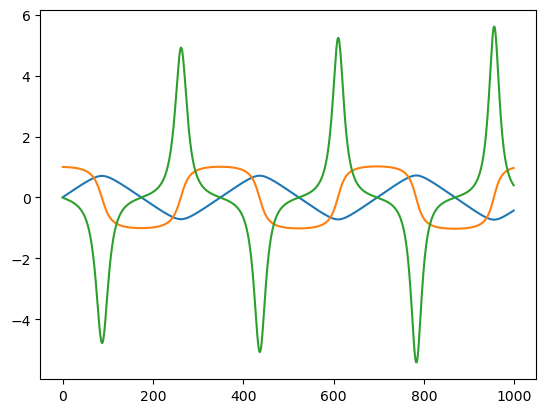

In [396]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm

def L(q,qdot,m,k,alpha):
    return 0.5*m*qdot**2 - 0.5*k*q**2 - alpha*q**2*qdot**2

"""
q = torch.tensor([1,2,3.])
qdot = torch.tensor([11,7,5.])
m = 1*torch.ones_like(q)
k = 2*torch.ones_like(q)
alpha = .2*torch.ones_like(q)
"""
"""
q = torch.tensor([1.1,1.3])
qdot = torch.tensor([2.3,2.5])
m = 1*torch.ones_like(q)
k = 2*torch.ones_like(q)
alpha = .2*torch.ones_like(q)
"""

its = 1000
dt = 0.01

qhist = torch.zeros(its)
qdothist = torch.zeros(its)
qddothist = torch.zeros(its)

q = torch.tensor([0],dtype=torch.float64)
qdot = torch.tensor([1],dtype=torch.float64)
m = 1*torch.ones_like(q)
k = 2*torch.ones_like(q)
alpha = 0.7*torch.ones_like(q)

g_q = torch.vmap(torch.func.jacfwd(L,argnums=0))
g_qdot = torch.vmap(torch.func.jacfwd(L,argnums=1))

g_q_qdot = (torch.func.jacfwd(g_qdot,argnums=0))
g_qdot_q = (torch.func.jacfwd(g_q,argnums=1))
g_qdot_qdot = (torch.func.jacfwd(g_qdot,argnums=1))

for i in tqdm.trange(its):
    q.data += dt*qdot
    #g_q = torch.vmap(torch.func.jacfwd(L,argnums=0))
    #g_qdot = torch.vmap(torch.func.jacfwd(L,argnums=1))
    
    #print(gq(q,qdot,m,k))
    t_g_q_qdot = g_q_qdot(q,qdot,m,k,alpha)
    t_g_qdot_q = g_qdot_q(q,qdot,m,k,alpha)
    t_g_qdot_qdot = g_qdot_qdot(q,qdot,m,k,alpha)
    
    D = torch.linalg.inv(t_g_qdot_qdot)
    #print(g_q(q,qdot,m,k,alpha))
    
    qddot = D@(g_q(q,qdot,m,k,alpha) - t_g_q_qdot@qdot)
    #q.data += dt*qdot
    qdot.data += dt*qddot

    qhist[i] = q.data
    qdothist[i] = qdot.data
    qddothist[i] = qddot.data

plt.plot(qhist)
plt.plot(qdothist)
plt.plot(qddothist)

100%|██████████| 500/500 [00:01<00:00, 413.47it/s]


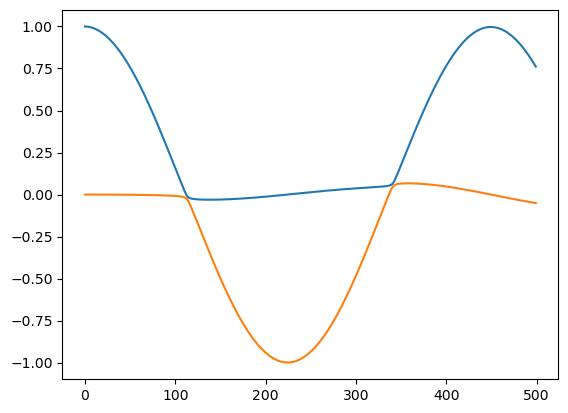

In [394]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm

def L(q,qdot,m,k,alpha):
    return torch.sum(0.5*m*qdot**2) - torch.sum(0.5*k*q**2) - alpha*torch.sum( torch.sqrt(1/( (q[0]-q[1])**2 )) )

"""
q = torch.tensor([1,2,3.])
qdot = torch.tensor([11,7,5.])
m = 1*torch.ones_like(q)
k = 2*torch.ones_like(q)
alpha = .2*torch.ones_like(q)
"""

q = torch.tensor([1.0,0],dtype=torch.float64)
qdot = torch.tensor([0,0],dtype=torch.float64)
#m = 1*torch.ones_like(q)
#k = 2*torch.ones_like(q)
#alpha = .01*torch.ones_like(q)
m = torch.tensor([1],dtype=torch.float64)
k = torch.tensor([2],dtype=torch.float64)
alpha = torch.tensor([.01],dtype=torch.float64)

its = 500
dt = 0.01

qhist = torch.zeros([2,its])
qdothist = torch.zeros([2,its])
qddothist = torch.zeros([2,its])

#print(L(q,qdot,m,k,alpha))

"""
g_q = torch.vmap(torch.func.jacfwd(L,argnums=0) )
g_qdot = torch.vmap(torch.func.jacfwd(L,argnums=1))

g_q_qdot = (torch.func.jacfwd(g_qdot,argnums=0))
g_qdot_q = (torch.func.jacfwd(g_q,argnums=1))
g_qdot_qdot = (torch.func.jacfwd(g_qdot,argnums=1))
"""

g_q = (torch.func.jacfwd(L,argnums=0) )
g_qdot = (torch.func.jacfwd(L,argnums=1))

g_q_qdot = (torch.func.jacfwd(g_qdot,argnums=0))
g_qdot_q = (torch.func.jacfwd(g_q,argnums=1))
g_qdot_qdot = (torch.func.jacfwd(g_qdot,argnums=1))

#print(g_q(q,qdot,m,k,alpha))

for i in tqdm.trange(its):
    q.data += dt*qdot

    t_g_q_qdot = g_q_qdot(q,qdot,m,k,alpha)
    t_g_qdot_q = g_qdot_q(q,qdot,m,k,alpha)
    t_g_qdot_qdot = g_qdot_qdot(q,qdot,m,k,alpha)
    
    D = torch.linalg.inv(t_g_qdot_qdot)[0]
    #print(D@(t_g_q_qdot@(qdot)).T)

    qddot = (D@g_q(q,qdot,m,k,alpha).T - D@(t_g_q_qdot@(qdot)).T).reshape(-1)
    qdot.data += dt*qddot

    qhist[:,i] = q.data
    qdothist[:,i] = qdot.data
    qddothist[:,i] = qddot.data

plt.plot(qhist[0,:])
plt.plot(qhist[1,:]) 
#plt.plot(qdothist)
#plt.plot(qddothist)


In [60]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm

n_points = 5
q_min = -1
q_max = 1
qdot_min = -1
qdot_max = 1

def L(q,qdot,m,k,alpha):
    return 0.5*m*qdot**2 - 0.5*k*q**2 - alpha*q**2*qdot**2



qgrid = torch.linspace(q_min,q_max,n_points)
qdotgrid = torch.linspace(qdot_min,qdot_max,n_points)

Q, QD = torch.meshgrid(qgrid, qdotgrid)

im = 0*torch.outer(qgrid,qdotgrid)

m = torch.tensor([1],dtype=torch.float64)
k = torch.tensor([2],dtype=torch.float64)
alpha = torch.tensor([0],dtype=torch.float64)

g_q = torch.vmap(torch.vmap((torch.func.jacfwd(L,argnums=0)),in_dims=(0,0,None,None,None)),in_dims=(0,0,None,None,None))
g_qdot = torch.vmap(torch.vmap((torch.func.jacfwd(L,argnums=1))),in_dims=(0,0,None,None,None))

g_q_qdot = torch.func.jacfwd(g_qdot,argnums=0)
g_qdot_q = torch.func.jacfwd(g_q,argnums=1)
#torch.vmap(torch.func.jacfwd(g_q,argnums=1),in_dims=(0,0,None,None,None))
g_qdot_qdot = torch.func.jacfwd(g_qdot,argnums=1)
#torch.vmap(torch.func.jacfwd(g_qdot,argnums=1),in_dims=(0,0,None,None,None))

t_g_q_qdot = g_q_qdot(Q,QD,m,k,alpha)
t_g_qdot_q = g_qdot_q(Q,QD,m,k,alpha)
t_g_qdot_qdot = g_qdot_qdot(Q,QD,m,k,alpha)

D = t_g_qdot_qdot**(-1)
#print(g_q(q,qdot,m,k,alpha))

print(t_g_qdot_q)
D*g_q(Q,QD,m,k,alpha)# - D*t_g_q_qdot*QD
#im = D*(g_q(Q,QD,m,k,alpha) - t_g_q_qdot*QD)

"""
for i in tqdm.trange(n_points):
    for j in range(n_points):

        t_g_q_qdot = g_q_qdot(qgrid[i],qdotgrid[j],m,k,alpha)
        t_g_qdot_q = g_qdot_q(qgrid[i],qdotgrid[j],m,k,alpha)
        t_g_qdot_qdot = g_qdot_qdot(qgrid[i],qdotgrid[j],m,k,alpha)
        
        D = t_g_qdot_qdot**(-1)
        #print(g_q(q,qdot,m,k,alpha))
        
        im[i,j] = D*(g_q(qgrid[i],qdotgrid[j],m,k,alpha) - t_g_q_qdot*qdotgrid[j])
"""        
plt.imshow(im)


RuntimeError: unsupported operation: more than one element of the written-to tensor refers to a single memory location. Please clone() the tensor before performing the operation.